# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import pandas as pd
import sympy as sp
import random 
plt.rcParams.update({'font.size': 20})

# Definitions

Function to define the properties of the axis of a plot

In [2]:
def my_axsis(ax, xlim, ylim, xticks, title, xtickslabels, bold=True, scale='lin'):    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_title(title)
    ax.set_xticklabels(xtickslabels)
    
    if bold==True:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)
            
    if scale=='log':
        ax.set_yscale('log', base=2)

Function to pick a random number in an interval centered around a standard value x_st 

In [5]:
def rand(x_st, length, perc=5): 
    x_rand = np.ones(len(length))
    x_min = x_st- x_st*perc/100
    x_max = x_st+ x_st*perc/100
    
    for i in range(len(length)): 
        x_rand[i] = np.round(random.uniform(x_min, x_max),4)
    
    return x_rand

# Model 

Definition of the parameters of the model 


In [6]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')

Solve the evolution equation for T (fraction of Ras-GTP)

In [7]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [8]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

 Definition of the function to compute Erk (as a function of T): 

In [9]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [Erk_max* T[i]**n/(T[i]**n +Kerk**n) + Erk_bas for i in range(len(T))]
    return Erk

# Import the experimental data 

In [10]:
#read the excel file with the experimental data
data_S1 = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

data_Fig2A = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Fig 2A & S1A')
df_Fig2A = pd.DataFrame(data_Fig2A)

data_Fig2B = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Fig 2B')
df_Fig2B = pd.DataFrame(data_Fig2B)

Experimental data figure 1C  

In [11]:
# Reltive area of cell surface contact with FGF expressing cells (divided by cell type)
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

Experimental data figure 2A

In [12]:
# Measured levels of Erk fluorescence (divided by cell type)
a65_Erk = np.array(df_Fig2A['a6.5'].values.tolist())
a66_Erk = np.array(df_Fig2A['a6.6'].values.tolist())
a67_Erk = np.array(df_Fig2A['a6.7'].values.tolist())
a68_Erk = np.array(df_Fig2A['a6.8'].values.tolist())

# Compute the mean of the experimental data
mean_a65_Erk = np.mean(a65_Erk)
mean_a66_Erk = np.mean(a66_Erk)
mean_a67_Erk = np.mean(a67_Erk)
mean_a68_Erk = np.mean(a68_Erk)

mean_Erk_exp = [mean_a68_Erk,mean_a66_Erk,mean_a67_Erk,mean_a65_Erk]

# Compute the standard deviation of the experimental data
sdev_a65_Erk_exp = np.std(a65_Erk)
sdev_a66_Erk_exp = np.std(a66_Erk)
sdev_a67_Erk_exp = np.std(a67_Erk)
sdev_a68_Erk_exp = np.std(a68_Erk)

Std_exp = [sdev_a68_Erk_exp,sdev_a66_Erk_exp,sdev_a67_Erk_exp,sdev_a65_Erk_exp]

Experimental data figure 2B

In [13]:
# Relative contact area with FGF-expressing cells 
RelContactArea_FGF = np.array(df_Fig2B['fgf relatif'].values.tolist())

# Relative contact area with FGF-expressing cells (divided by cell type)
a65_S1 = np.array(df_Fig2B['a6.5 fgf relatif'].values.tolist())
a66_S1 = np.array(df_Fig2B['a6.6 fgf relatif'].values.tolist())
a67_S1 = np.array(df_Fig2B['a6.7 fgf relatif'].values.tolist())
a68_S1 = np.array(df_Fig2B['a6.8 fgf relatif'].values.tolist())

# Corresponding level of Erk fluorescence (divided by cell type)
a65_Erk_1E = np.array(df_Fig2B['a6.5 dpERK'].values.tolist())
a66_Erk_1E = np.array(df_Fig2B['a6.6 dpERK'].values.tolist())
a67_Erk_1E = np.array(df_Fig2B['a6.7 dpERK'].values.tolist())
a68_Erk_1E = np.array(df_Fig2B['a6.8 dpERK'].values.tolist())

# Results

## Figure 2A

### Model predictions

In [14]:
# Parameter values: 
Erk_m= 1850    
Erk_b = np.mean(a68_Erk)   

Compute Erk activity 

In [15]:
# Compute T
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]

# Compute Erk
Erk_pred_a65_a = Erk(T_pred_a65)
Erk_pred_a66_a = Erk(T_pred_a66)
Erk_pred_a67_a = Erk(T_pred_a67)
Erk_pred_a68_a = Erk(T_pred_a68)

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Erk_model_a= np.mean(Erk_pred_a65_a) 
mean_a66_Erk_model_a= np.mean(Erk_pred_a66_a)
mean_a67_Erk_model_a= np.mean(Erk_pred_a67_a)
mean_a68_Erk_model_a= np.mean(Erk_pred_a68_a)
Erk_mean_a = [mean_a65_Erk_model_a, mean_a66_Erk_model_a, mean_a67_Erk_model_a, mean_a68_Erk_model_a]

# Compute the std
sdev_a65_Erk_model_a = np.std(Erk_pred_a65_a)
sdev_a66_Erk_model_a = np.std(Erk_pred_a66_a)
sdev_a67_Erk_model_a = np.std(Erk_pred_a67_a)
sdev_a68_Erk_model_a = np.std(Erk_pred_a68_a)

Compute Erk fluorescence 

In [16]:
Erk_max= 1850    
Erk_bas = np.mean(a68_Erk)  

Erk_pred_a65_f = Erk(T_pred_a65, Erk_max=Erk_m, Erk_bas =Erk_b)
Erk_pred_a66_f = Erk(T_pred_a66, Erk_max=Erk_m, Erk_bas =Erk_b)
Erk_pred_a67_f = Erk(T_pred_a67, Erk_max=Erk_m, Erk_bas =Erk_b)
Erk_pred_a68_f = Erk(T_pred_a68, Erk_max=Erk_m, Erk_bas =Erk_b)

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Erk_model_f= np.mean(Erk_pred_a65_f) 
mean_a66_Erk_model_f= np.mean(Erk_pred_a66_f)
mean_a67_Erk_model_f= np.mean(Erk_pred_a67_f)
mean_a68_Erk_model_f= np.mean(Erk_pred_a68_f)
Erk_mean_f = [mean_a65_Erk_model_f, mean_a66_Erk_model_f, mean_a67_Erk_model_f, mean_a68_Erk_model_f]

# Compute the std
sdev_a65_Erk_model_f = np.sqrt(Erk_max**2*sdev_a65_Erk_model_a**2+sdev_a68_Erk_exp**2)
sdev_a66_Erk_model_f = np.sqrt(Erk_max**2*sdev_a66_Erk_model_a**2+sdev_a68_Erk_exp**2)
sdev_a67_Erk_model_f = np.sqrt(Erk_max**2*sdev_a67_Erk_model_a**2+sdev_a68_Erk_exp**2)
sdev_a68_Erk_model_f = np.sqrt(Erk_max**2*sdev_a68_Erk_model_a**2+sdev_a68_Erk_exp**2)

### Comparison with experimental data

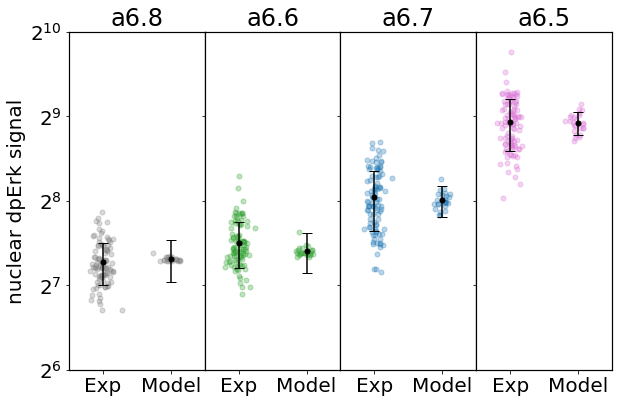

In [17]:
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1,4, hspace=0,wspace=0)
axs = gs.subplots(sharey=True)

# a6.8 
x = np.random.normal(1, 0.08, size=len(a68_Erk))
axs[0].plot(x,a68_Erk,'.', color='grey', alpha=0.3,markersize=10,zorder=1)

x = 1 
axs[0].errorbar(x,mean_a68_Erk ,sdev_a68_Erk_exp, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Erk_pred_a68_f))
axs[0].plot(x,Erk_pred_a68_f,'.', color='grey', alpha=0.3,markersize=10,zorder=1)

x = 2 
axs[0].errorbar(x,mean_a68_Erk_model_f ,sdev_a68_Erk_model_f, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[0], xlim=[0.5,2.5], ylim=[2**6,2**(10)], xticks=[1,2], title='a6.8', xtickslabels=['Exp', 'Model'], bold=True, scale='log')
axs[0].set_ylabel('nuclear dpErk signal')
   
# a6.6 
x = np.random.normal(1, 0.08, size=len(a66_Erk))
axs[1].plot(x,a66_Erk,'.', color='tab:green', alpha=0.3, markersize=10,zorder=1)

x = 1 
axs[1].errorbar(x,mean_a66_Erk ,sdev_a66_Erk_exp, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Erk_pred_a66_f))
axs[1].plot(x,Erk_pred_a66_f,'.', color='tab:green', alpha=0.3, markersize=10,zorder=1)

x = 2 
axs[1].errorbar(x,mean_a66_Erk_model_f ,sdev_a66_Erk_model_f, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[1], xlim=[0.5,2.5], ylim=[2**6,2**(10)], xticks=[1,2], title='a6.6', xtickslabels=['Exp', 'Model'], bold=True, scale='log')

# a6.7 
x = np.random.normal(1, 0.08, size=len(a67_Erk))
axs[2].plot(x,a67_Erk,'.', color='tab:blue', alpha=0.3,markersize=10,zorder=1)

x = 1 
axs[2].errorbar(x,mean_a67_Erk ,sdev_a67_Erk_exp, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Erk_pred_a67_f))
axs[2].plot(x,Erk_pred_a67_f,'.', color='tab:blue', alpha=0.3,markersize=10,zorder=1)

x = 2 
axs[2].errorbar(x,mean_a67_Erk_model_f ,sdev_a67_Erk_model_f, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[2], xlim=[0.5,2.5], ylim=[2**6,2**(10)], xticks=[1,2], title='a6.7', xtickslabels=['Exp', 'Model'], bold=True, scale='log')

# a6.5
x = np.random.normal(1, 0.08, size=len(a65_Erk))
axs[3].plot(x,a65_Erk,'.', color='orchid', alpha=0.3,markersize=10,zorder=1)

x = 1 
axs[3].errorbar(x,mean_a65_Erk ,sdev_a65_Erk_exp, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

x = np.random.normal(2, 0.08, size=len(Erk_pred_a65_f))
axs[3].plot(x,Erk_pred_a65_f,'.', color='orchid', alpha=0.3,markersize=10,zorder=1)

x = 2 
axs[3].errorbar(x,mean_a65_Erk_model_f ,sdev_a65_Erk_model_f, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

my_axsis(axs[3], xlim=[0.5,2.5], ylim=[2**6,2**(10)], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'], bold=True, scale='log')

plt.tight_layout()
plt.show()


## Figure 2B

### Model predictions

Compute Erk activity and Erk fluorescence  

In [18]:
S1_temp = np.linspace(0.03, 0.42, 100) 

T_pred_model1E = [exprT(S1_v= S1_temp[i]) for i in range(len(S1_temp))]

# Compute Erk activity 
Erk_pred_model1E_a =  Erk(T_pred_model1E)

# Compute Erk fluorescence 
Erk_m= 3000  
Erk_b = np.nanmean(a68_Erk_1E)  

T_pred_model1E = [exprT(S1_v= S1_temp[i]) for i in range(len(S1_temp))]
Erk_pred_model1E_f = Erk(T_pred_model1E, Erk_max =Erk_m, Erk_bas= Erk_b)

Error_Erk_f = np.nanstd(a68_Erk_1E)*np.ones(len(Erk_pred_model1E_f))  
Error_piu = Erk_pred_model1E_f + Error_Erk_f
Error_meno = Erk_pred_model1E_f - Error_Erk_f

Compute Erk activity and fluorescence starting from the exp data of S1 of figure 1E 

In [19]:
T_pred_1E = [exprT(S1_v= RelContactArea_FGF[i]) for i in range(len(RelContactArea_FGF))]

# Compute Erk activity 
Erk_pred_1E_a =  Erk(T_pred_1E)

# Compute Erk fluorescence 
Erk_pred_1E_f = Erk(T_pred_1E, Erk_max =Erk_m, Erk_bas= Erk_b)
Error_Erk_f = np.nanstd(a68_Erk_1E)*np.ones(len(Erk_pred_1E_f)) 

### Comparison with experimental data

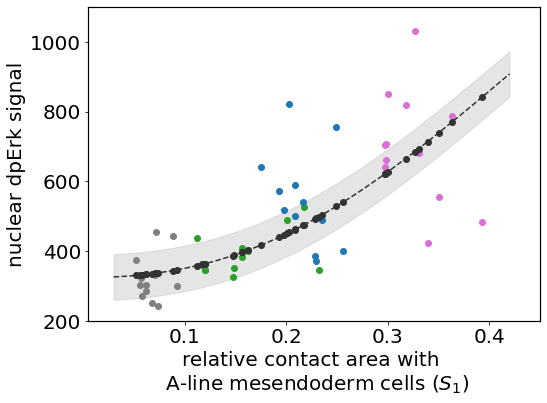

In [20]:
fig= plt.figure(figsize=(8,6))
plt.plot(RelContactArea_FGF, Erk_pred_1E_f,'o',markersize=6,alpha=1, color= '0.2', label='Model predictions', zorder=2)

plt.plot(a65_S1, a65_Erk_1E,'.', markersize=12, color='orchid', zorder=1)
plt.plot(a66_S1, a66_Erk_1E,'.', markersize=12, color='tab:green', zorder=1)
plt.plot(a67_S1, a67_Erk_1E,'.', markersize=12, color='tab:blue', zorder=1)
plt.plot(a68_S1, a68_Erk_1E,'.', markersize=12, color='grey', zorder=1, label='Experimental data \n cell a6.8')

plt.plot(S1_temp, Erk_pred_model1E_f,'--', color='0.2')
plt.fill_between(S1_temp, Error_meno, Error_piu, color='grey', alpha=0.2)

plt.xlabel('relative contact area with \n A-line mesendoderm cells ($S_1$)')
plt.ylabel('nuclear dpErk signal')
ax = fig.gca()
my_axsis(ax, xlim=[0.005,0.45], ylim=[200,1100], xticks=[0.1,0.2,0.3,0.4], title='', xtickslabels=['0.1', '0.2', '0.3','0.4'], bold=True, scale='lin')
plt.tight_layout()
plt.show()

## Figure 4A

Definition of the random parameters

In [21]:
p = 20
length= a65_RelContactArea_A

FGF_rand_a65 = rand(5, length, perc=p)
FGF_rand_a66 = rand(5, length, perc=p)
FGF_rand_a67 = rand(5, length, perc=p)
FGF_rand_a68 = rand(5, length, perc=p)

E_rand_a65 = rand(5, length, perc=p)
E_rand_a66 = rand(5, length, perc=p)
E_rand_a67 = rand(5, length, perc=p)
E_rand_a68 = rand(5, length, perc=p)

Rt_rand_a65 = rand(2000, length, perc=p)
Rt_rand_a66 = rand(2000, length, perc=p)
Rt_rand_a67 = rand(2000, length, perc=p)
Rt_rand_a68 = rand(2000, length, perc=p)

Qt_rand_a65 = rand(2000, length, perc=p)
Qt_rand_a66 = rand(2000, length, perc=p)
Qt_rand_a67 = rand(2000, length, perc=p)
Qt_rand_a68 = rand(2000, length, perc=p)

Kd_rand_a65 = rand(25, length, perc=p)
Kd_rand_a66 = rand(25, length, perc=p)
Kd_rand_a67 = rand(25, length, perc=p)
Kd_rand_a68 = rand(25, length, perc=p)

Ke_rand_a65 = rand(50, length, perc=p)
Ke_rand_a66 = rand(50, length, perc=p)
Ke_rand_a67 = rand(50, length, perc=p)
Ke_rand_a68 = rand(50, length, perc=p)

Kb_rand_a65 = rand(0.2, length, perc=p)
Kb_rand_a66 = rand(0.2, length, perc=p)
Kb_rand_a67 = rand(0.2, length, perc=p)
Kb_rand_a68 = rand(0.2, length, perc=p)

K1_rand_a65 = rand(0.5, length, perc=p)
K1_rand_a66 = rand(0.5, length, perc=p)
K1_rand_a67 = rand(0.5, length, perc=p)
K1_rand_a68 = rand(0.5, length, perc=p)

K2_rand_a65 = rand(0.2, length, perc=p)
K2_rand_a66 = rand(0.2, length, perc=p)
K2_rand_a67 = rand(0.2, length, perc=p)
K2_rand_a68 = rand(0.2, length, perc=p)

Krg_rand_a65 = rand(1200, length, perc=p)
Krg_rand_a66 = rand(1200, length, perc=p)
Krg_rand_a67 = rand(1200, length, perc=p)
Krg_rand_a68 = rand(1200, length, perc=p)

Ks_rand_a65 = rand(1200, length, perc=p)
Ks_rand_a66 = rand(1200, length, perc=p)
Ks_rand_a67 = rand(1200, length, perc=p)
Ks_rand_a68 = rand(1200, length, perc=p)

Vrg_rand_a65 = rand(0.4, length, perc=p)
Vrg_rand_a66 = rand(0.4, length, perc=p)
Vrg_rand_a67 = rand(0.4, length, perc=p)
Vrg_rand_a68 = rand(0.4, length, perc=p)

Vs_rand_a65 = rand(1, length, perc=p)
Vs_rand_a66 = rand(1, length, perc=p)
Vs_rand_a67 = rand(1, length, perc=p)
Vs_rand_a68 = rand(1, length, perc=p)

Kerk_rand_a65 = rand(0.5, length, perc=p)
Kerk_rand_a66 = rand(0.5, length, perc=p)
Kerk_rand_a67 = rand(0.5, length, perc=p)
Kerk_rand_a68 = rand(0.5, length, perc=p)

### Parameters linked to the FGF pathway randomly choosen 

In [22]:
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i], F_v=FGF_rand_a65[i], Kd_v=Kd_rand_a65[i],Ks_v=Ks_rand_a65[i], Rtot_v=Rt_rand_a65[i],Vs_v=Vs_rand_a65[i],K1_v =K1_rand_a65[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i], F_v=FGF_rand_a66[i], Kd_v=Kd_rand_a66[i],Ks_v=Ks_rand_a66[i], Rtot_v=Rt_rand_a66[i],Vs_v=Vs_rand_a65[i],K1_v =K1_rand_a66[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i], F_v=FGF_rand_a67[i], Kd_v=Kd_rand_a67[i],Ks_v=Ks_rand_a67[i], Rtot_v=Rt_rand_a67[i],Vs_v=Vs_rand_a65[i],K1_v =K1_rand_a67[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i], F_v=FGF_rand_a68[i], Kd_v=Kd_rand_a68[i],Ks_v=Ks_rand_a68[i], Rtot_v=Rt_rand_a68[i],Vs_v=Vs_rand_a65[i],K1_v =K1_rand_a68[i]) for i in range(len(a68_RelContactArea_A))]

Erk_pred_a65_a = Erk(T_pred_a65)
Erk_pred_a66_a = Erk(T_pred_a66)
Erk_pred_a67_a = Erk(T_pred_a67)
Erk_pred_a68_a = Erk(T_pred_a68)

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Erk_model_a= np.mean(Erk_pred_a65_a) 
mean_a66_Erk_model_a= np.mean(Erk_pred_a66_a)
mean_a67_Erk_model_a= np.mean(Erk_pred_a67_a)
mean_a68_Erk_model_a= np.mean(Erk_pred_a68_a)
Erk_mean_a = [mean_a65_Erk_model_a, mean_a66_Erk_model_a, mean_a67_Erk_model_a, mean_a68_Erk_model_a]

# Compute the std
sdev_a65_Erk_model_a = np.std(Erk_pred_a65_a)
sdev_a66_Erk_model_a = np.std(Erk_pred_a66_a)
sdev_a67_Erk_model_a = np.std(Erk_pred_a67_a)
sdev_a68_Erk_model_a = np.std(Erk_pred_a68_a)
sdev_a = [sdev_a65_Erk_model_a, sdev_a66_Erk_model_a, sdev_a67_Erk_model_a, sdev_a68_Erk_model_a]

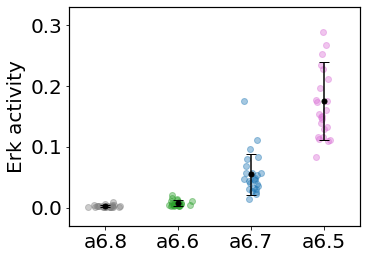

In [23]:
plt.figure(figsize=(5.5,4))

x = np.random.normal(1, 0.08, size=len(Erk_pred_a68_a)) 
plt.plot(x,Erk_pred_a68_a,'.', color='grey', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(2, 0.08, size=len(Erk_pred_a66_a))
plt.plot(x,Erk_pred_a66_a,'.', color='tab:green', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(3, 0.08, size=len(Erk_pred_a67_a))
plt.plot(x,Erk_pred_a67_a,'.', color='tab:blue', alpha=0.4,markersize=12, zorder=1)

x = np.random.normal(4, 0.08, size=len(Erk_pred_a65_a))
plt.plot(x,Erk_pred_a65_a,'.', color='orchid', alpha=0.4,markersize=12, zorder=1)

x = [4, 2, 3, 1]
plt.errorbar(x, Erk_mean_a, sdev_a, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

ax=plt.gca()
my_axsis(ax, xlim=[0.5,4.5], ylim=[-0.03,0.33], xticks=[1,2,3,4], title='', xtickslabels=['a6.8', 'a6.6', 'a6.7','a6.5'], bold=True)
plt.ylabel('Erk activity')
plt.tight_layout()
plt.show()

### Parameters linked to the ephrin pathway randomly choosen

In [24]:
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i], E_v=E_rand_a65[i], Ke_v=Ke_rand_a65[i],Krg_v=Krg_rand_a65[i], Qtot_v=Qt_rand_a65[i],Vrg_v=Vrg_rand_a65[i],K2_v =K2_rand_a65[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i], E_v=E_rand_a66[i], Ke_v=Ke_rand_a66[i],Krg_v=Krg_rand_a66[i], Qtot_v=Qt_rand_a66[i],Vrg_v=Vrg_rand_a65[i],K2_v =K2_rand_a66[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i], E_v=E_rand_a67[i], Ke_v=Ke_rand_a67[i],Krg_v=Krg_rand_a67[i], Qtot_v=Qt_rand_a67[i],Vrg_v=Vrg_rand_a65[i],K2_v =K2_rand_a67[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i], E_v=E_rand_a68[i], Ke_v=Ke_rand_a68[i],Krg_v=Krg_rand_a68[i], Qtot_v=Qt_rand_a68[i],Vrg_v=Vrg_rand_a65[i],K2_v =K2_rand_a68[i]) for i in range(len(a68_RelContactArea_A))]

Erk_pred_a65_a = Erk(T_pred_a65)
Erk_pred_a66_a = Erk(T_pred_a66)
Erk_pred_a67_a = Erk(T_pred_a67)
Erk_pred_a68_a = Erk(T_pred_a68)

# Compute the mean Erk value for each cell type (with our model)
mean_a65_Erk_model_a= np.mean(Erk_pred_a65_a) 
mean_a66_Erk_model_a= np.mean(Erk_pred_a66_a)
mean_a67_Erk_model_a= np.mean(Erk_pred_a67_a)
mean_a68_Erk_model_a= np.mean(Erk_pred_a68_a)
Erk_mean_a = [mean_a65_Erk_model_a, mean_a66_Erk_model_a, mean_a67_Erk_model_a, mean_a68_Erk_model_a]

# Compute the std
sdev_a65_Erk_model_a = np.std(Erk_pred_a65_a)
sdev_a66_Erk_model_a = np.std(Erk_pred_a66_a)
sdev_a67_Erk_model_a = np.std(Erk_pred_a67_a)
sdev_a68_Erk_model_a = np.std(Erk_pred_a68_a)
sdev_a = [sdev_a65_Erk_model_a, sdev_a66_Erk_model_a, sdev_a67_Erk_model_a, sdev_a68_Erk_model_a]

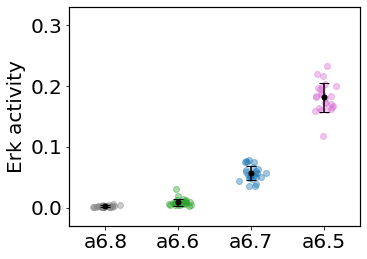

In [25]:
plt.figure(figsize=(5.5,4))

x = np.random.normal(1, 0.08, size=len(Erk_pred_a68_a))
plt.plot(x,Erk_pred_a68_a,'.', color='grey', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(2, 0.08, size=len(Erk_pred_a66_a))
plt.plot(x,Erk_pred_a66_a,'.', color='tab:green', alpha=0.4,markersize=12, zorder=1)
    
x = np.random.normal(3, 0.08, size=len(Erk_pred_a67_a))
plt.plot(x,Erk_pred_a67_a,'.', color='tab:blue', alpha=0.4,markersize=12, zorder=1)

x = np.random.normal(4, 0.08, size=len(Erk_pred_a65_a))
plt.plot(x,Erk_pred_a65_a,'.', color='orchid', alpha=0.4,markersize=12, zorder=1)

x = [4, 2, 3, 1]
plt.errorbar(x, Erk_mean_a, sdev_a, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

ax=plt.gca()
my_axsis(ax, xlim=[0.5,4.5], ylim=[-0.03, 0.33], xticks=[1,2,3,4], title='', xtickslabels=['a6.8', 'a6.6', 'a6.7','a6.5'], bold=True)

plt.ylabel('Erk activity')
plt.tight_layout()
plt.show()